In [1]:
import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision.datasets as datasets
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader


In [2]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.conv1 = self._block(channels_img, features_d, 4, 2, 1)
        self.conv2 = self._block(features_d, features_d * 2, 4, 2, 1)
        self.conv3 = self._block(features_d * 2, features_d * 4, 4, 2, 1)
        self.conv4 = self._block(features_d * 4, features_d * 8, 4, 2, 1)
        self.conv5 = nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0)
        self.activation = nn.Sigmoid()

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.activation(x)
        return x


In [3]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.conv1 = self._block(channels_noise, features_g * 16, 4, 1, 0)  # img: 4x4
        self.conv2 = self._block(features_g * 16, features_g * 8, 4, 2, 1)  # img: 8x8
        self.conv3 = self._block(features_g * 8, features_g * 4, 4, 2, 1)  # img: 16x16
        self.conv4 = self._block(features_g * 4, features_g * 2, 4, 2, 1)  # img: 32x32
        self.conv5 = nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1)
        self.activation = nn.Tanh()

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.activation(x)
        return x


In [4]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
#from model import Discriminator, Generator, initialize_weights

# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 10
FEATURES_DISC = 64
FEATURES_GEN = 64

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

# If you train on MNIST, remember to set channels_img to 1
# dataset = datasets.MNIST(
#     root="dataset/", train=True, transform=transforms, download=True
# )

# comment mnist above and uncomment below if train on CelebA
dataset = datasets.DatasetFolder(
    root="dataset/",
    loader=torchvision.datasets.folder.default_loader,
    extensions=('.jpg', '.jpeg', '.png', '.bmp'),  
    transform=transforms,
)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
log_directory = r"e:E:\s1\testDCGAN\logs"
#E:\s1\testDCGAN

writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()

# Initialize empty lists to store losses
losses_disc = []
losses_gen = []

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Store losses
        losses_disc.append(loss_disc.item())
        losses_gen.append(loss_gen.item())

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

# Save losses to a file
torch.save(losses_disc, 'losses_disc.pt')
torch.save(losses_gen, 'losses_gen.pt')


Epoch [0/10] Batch 0/1875                   Loss D: 0.6868, loss G: 0.6866
Epoch [0/10] Batch 100/1875                   Loss D: 0.4475, loss G: 0.6133
Epoch [0/10] Batch 200/1875                   Loss D: 0.3676, loss G: 0.7231
Epoch [0/10] Batch 300/1875                   Loss D: 0.4415, loss G: 0.6523
Epoch [0/10] Batch 400/1875                   Loss D: 0.4077, loss G: 0.7113
Epoch [0/10] Batch 500/1875                   Loss D: 1.6940, loss G: 0.5301
Epoch [0/10] Batch 600/1875                   Loss D: 0.4073, loss G: 0.8255
Epoch [0/10] Batch 700/1875                   Loss D: 0.2666, loss G: 1.2933
Epoch [0/10] Batch 800/1875                   Loss D: 0.4473, loss G: 0.7546
Epoch [0/10] Batch 900/1875                   Loss D: 0.4782, loss G: 0.7325
Epoch [0/10] Batch 1000/1875                   Loss D: 0.3828, loss G: 0.8021
Epoch [0/10] Batch 1100/1875                   Loss D: 0.6525, loss G: 0.7754
Epoch [0/10] Batch 1200/1875                   Loss D: 0.6010, loss G: 0.630

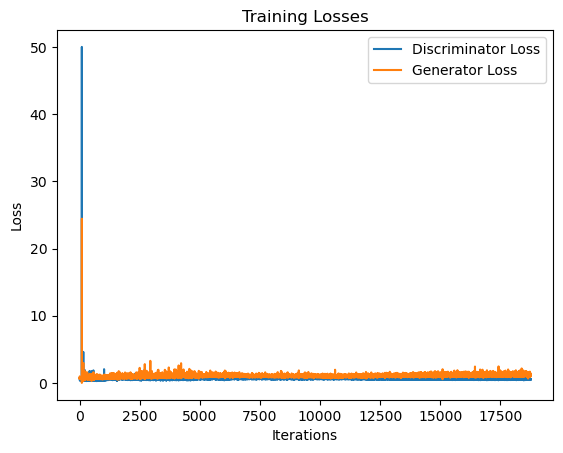

In [8]:
import torch
import matplotlib.pyplot as plt

# Load saved loss values
losses_disc = torch.load('losses_disc.pt')
losses_gen = torch.load('losses_gen.pt')

# Create x-axis values (iterations or batches)
x = range(len(losses_disc))

# Plot the losses
plt.plot(x, losses_disc, label='Discriminator Loss')
plt.plot(x, losses_gen, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()


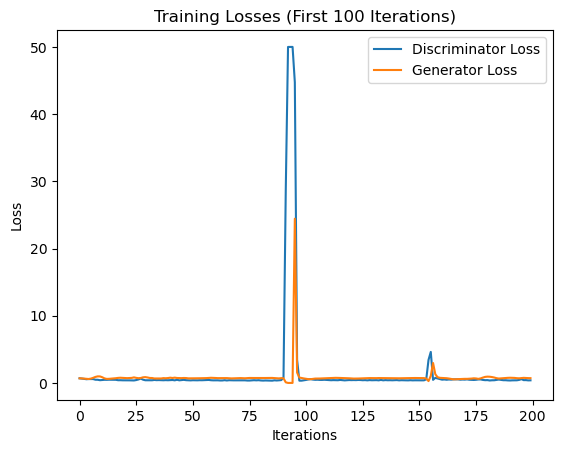

In [10]:
import torch
import matplotlib.pyplot as plt

# Load saved loss values
losses_disc = torch.load('losses_disc.pt')[:200]
losses_gen = torch.load('losses_gen.pt')[:200]

# Create x-axis values (iterations or batches)
x = range(len(losses_disc))

# Plot the losses
plt.plot(x, losses_disc, label='Discriminator Loss')
plt.plot(x, losses_gen, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Losses (First 100 Iterations)')
plt.legend()
plt.show()
